# 0.0 IMPORTS

In [1]:
import math
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from scipy                 import stats as ss
from boruta                import BorutaPy
from datetime              import timedelta
from IPython.display       import Image
from sklearn.ensemble      import RandomForestRegressor
from matplotlib.pyplot     import GridSpec
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [2]:
# cramer's V calculation function
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. DATA DESCRIPTION

## 0.1 Looking at the columns names

In [6]:
#Fazendo uma cópia do dataset para a próxima seção,
#para que nao seja necessario rodar todo o script novamente, no caso de sobre-escrever a variável por exemplo.

df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [9]:
print('Rows: {}'.format(df1.shape[0]) )
print('Columns: {}'.format(df1.shape[1]) )

Rows: 1017209
Columns: 18


## 1.3 Data Types

In [10]:
df1.dtypes

#Precisamos alterar a coluna 'date' para formato de DATA (dia/mes/ano)

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

#Coluna alterada. Agora aparece no dtypes como 'datetime64'

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA (Missing Values). 
How to handle them?

* Drop NA Columns (not recommended)
* Input missing values with mean or median. (when you don't have business information)
* Understand the business: Why there are missing values? (Knowing the rules of why there is missing values in the dataset, you may retrieve them).

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [16]:
#COLUMNS WITH MISSING VALUES

#competition_distance            
#competition_open_since_month    
#competition_open_since_year     
#promo2_since_week               
#promo2_since_year               
#promo_interval                  

In [17]:
#What's the maximum value in 'competition_distance'?
df1['competition_distance'].max()

75860.0

In [13]:
#'competition_distance' (distance in meters to the nearest competitor store)
# - Assumption: If there's no value, it might mean that this store doesn't have any near competitor or the nearest one is too far to be 
# a potential competitor.

# *We are telling PYTHON to apply a 200.000m value (way higher than the maximum distance) if the field is NaN, 
# 'cuz there's no competition to such store:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# 'competition_open_since_month' (since when the nearest competitor is open?)
# - Assumption: If there's value in 'competition_distance', we should have the information of since when we have this competitor)

# *So we are going to retrive this information from column 'date', extracting the MONTH data:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if
                                                math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

# 'competition_open_since_year'
# *Doing it again but to retrieve YEAR information now:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if
                                                math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

# 'promo2_since_week' (describes the calendar week when the store started participating in Promo2)
# *Let's repeat the operation with this column, since we need to give some information to the algorithm further:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if
                                                math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)

# 'promo2_since_year' (describes the calendar year when the store started participating in Promo2)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if
                                                math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)

# 'promo_interval' (describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
# E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store)

#Creating a dictionary to replace the numbers with month names:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

#Creating the new column
df1['month_map'] = df1['date'].dt.month.map(month_map)

#Creating a new column from a condition, to tell us if promo is active in the given store.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
925245,581,7,2013-03-24,0,0,0,0,0,0,a,a,7250.0,12.0,2013.0,0,12.0,2013.0,0,Mar,0
426873,614,6,2014-06-14,5330,814,1,0,0,0,a,a,1160.0,12.0,2012.0,0,24.0,2014.0,0,Jun,0
595818,79,1,2014-01-13,4245,529,1,0,0,0,a,a,3320.0,1.0,2014.0,0,3.0,2014.0,0,Jan,0
298534,530,7,2014-10-26,4058,716,1,0,0,0,a,c,18160.0,10.0,2014.0,0,43.0,2014.0,0,Oct,0
782315,371,2,2013-07-30,8820,606,1,1,0,1,d,c,1970.0,7.0,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov",Jul,0


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Check DTypes

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
#Changing dtypes - Some columns need to be filled with 'int' dtype instead 'float64':

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [19]:
#Numerical variables only
num_attributes = df1.select_dtypes(include=['int64','int32', 'float64'])

#Categorical variables only
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [20]:
num_attributes.sample(3)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
417736,397,7,0,0,0,0,0,130.0,6,2014,1,27,2013,0
397057,950,7,0,0,0,0,0,8460.0,11,1994,0,28,2014,0
867389,705,3,9435,1090,1,1,0,4140.0,9,2012,1,18,2011,1


In [21]:
cat_attributes.sample(3)

,state_holiday,store_type,assortment,promo_interval,month_map
600638,0,a,a,0,Jan
736452,0,d,c,"Jan,Apr,Jul,Oct",Sep
846973,0,d,c,0,Jun


## 1.7.1 Numerical Atributes

In [22]:
#Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispertion - standart deviation(std), min, max, range, skew (data asymmetry), kurtosis (high/low-tendency of the data, outliers identifier)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Thiago\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

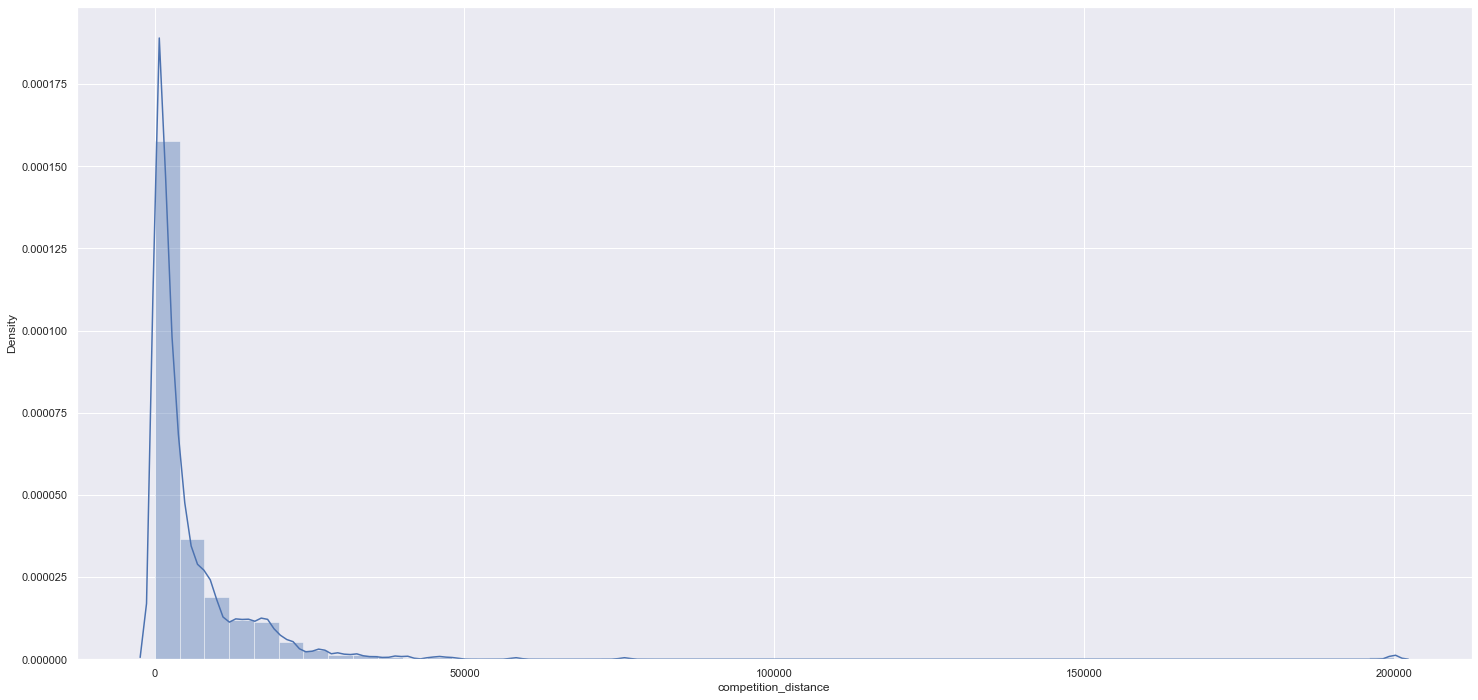

In [25]:
#Visualizing the distribuition of a given column

sns.distplot(df1['competition_distance'])

## 1.7.2 Categorical Atributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

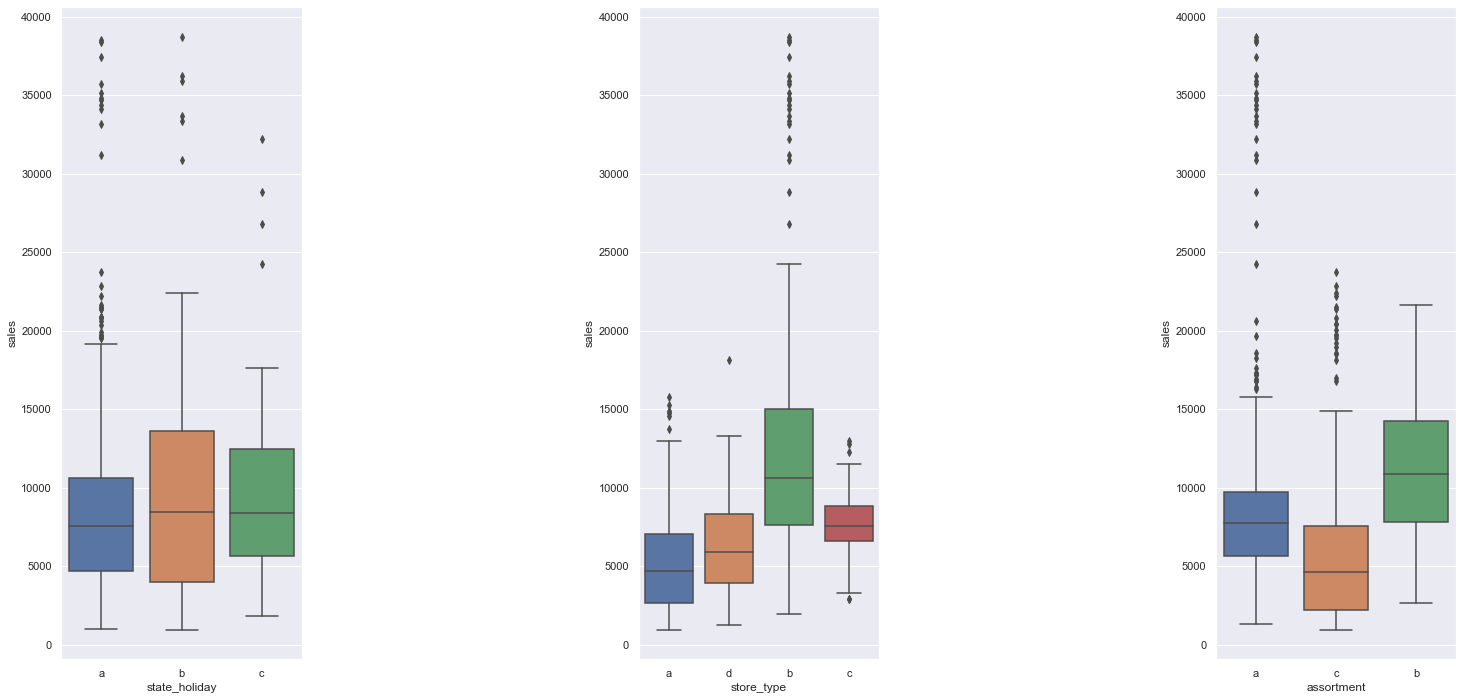

In [24]:
#plotting categorical atributes

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 5, 1)
sns.boxplot(x= 'state_holiday', y= 'sales', data=aux1)

plt.subplot(1, 5, 3)
sns.boxplot(x= 'store_type', y= 'sales', data=aux1)

plt.subplot(1, 5, 5)
sns.boxplot(x= 'assortment', y= 'sales', data=aux1)

# 2.0 FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1 Criaçao das Hipoteses

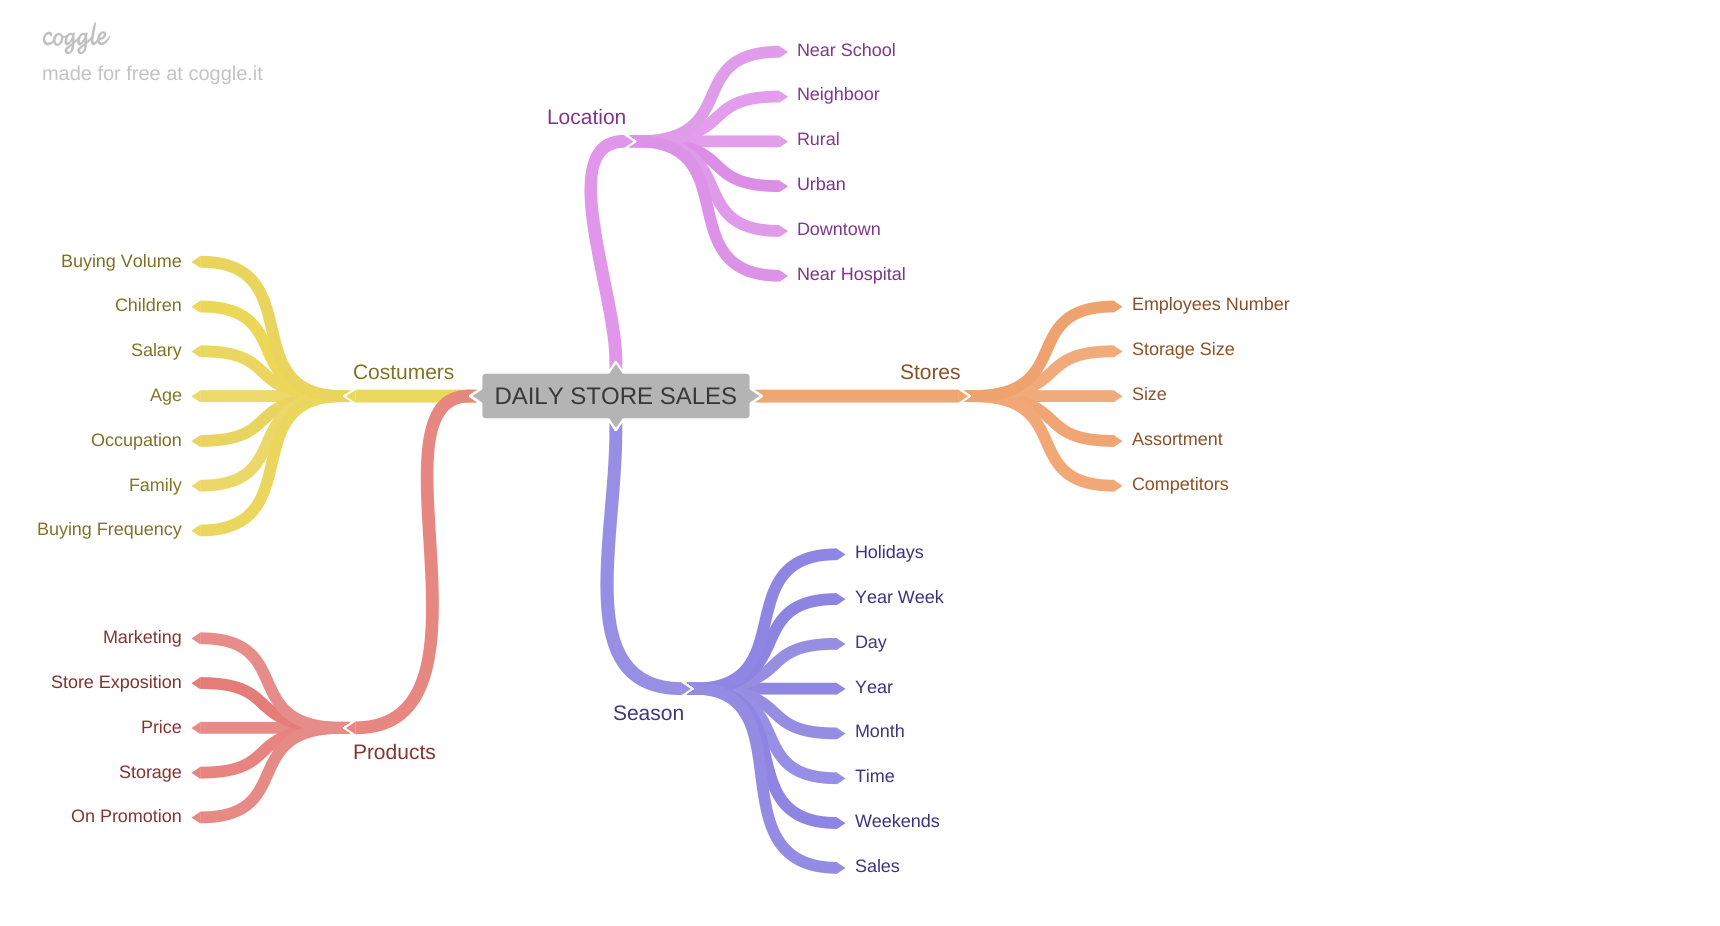

In [32]:
#MAPA MENTAL DE HIPÓTESES

Image('img/mind_map_hypothesis.png')

### 2.1.1 Hipotese Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas maiores deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.


### 2.1.2 Hipotese Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas com mais dias de promoção deveriam vender mais.

### 2.1.3 Hipotese Temporal (Sazonalidade)

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriado escolares.

## 2.2 Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas abertas durante o feriado de natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriado escolares.


## 2.3 Feature Engineering

Variáveis a serem derivadas da variável original:

In [27]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since 
#(juntar as infos das colunas 'competition_open_since_year' e 'competition_open_since_month' numa única coluna)
df2['competition_since'] = df2.apply (lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)
                                     
#assortment (sobrescrevendo a mesma variável aplicando as classificaçãoes 'basic', 'extra' e 'extended')
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x =='b' else 'extended')

#state_holiday 
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x =='b' else 'christimas' if x=='c' else 'regular_day')

<ipython-input-27-de7267b2cfb8>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VARIABLE FILTERING

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [31]:
#Excluindo linhas onde a coluna 'sales' é igual a ZERO e onde a coluna 'open' é igual a ZERO (indicando que loja estava fechada)
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1 Seleção das Colunas

In [32]:
#Excluindo colunas que não serão relevantes
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

In [34]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

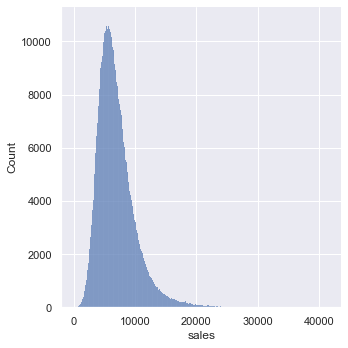

In [35]:
sns.displot (df4['sales']);

### 4.1.2 Numerical Variable

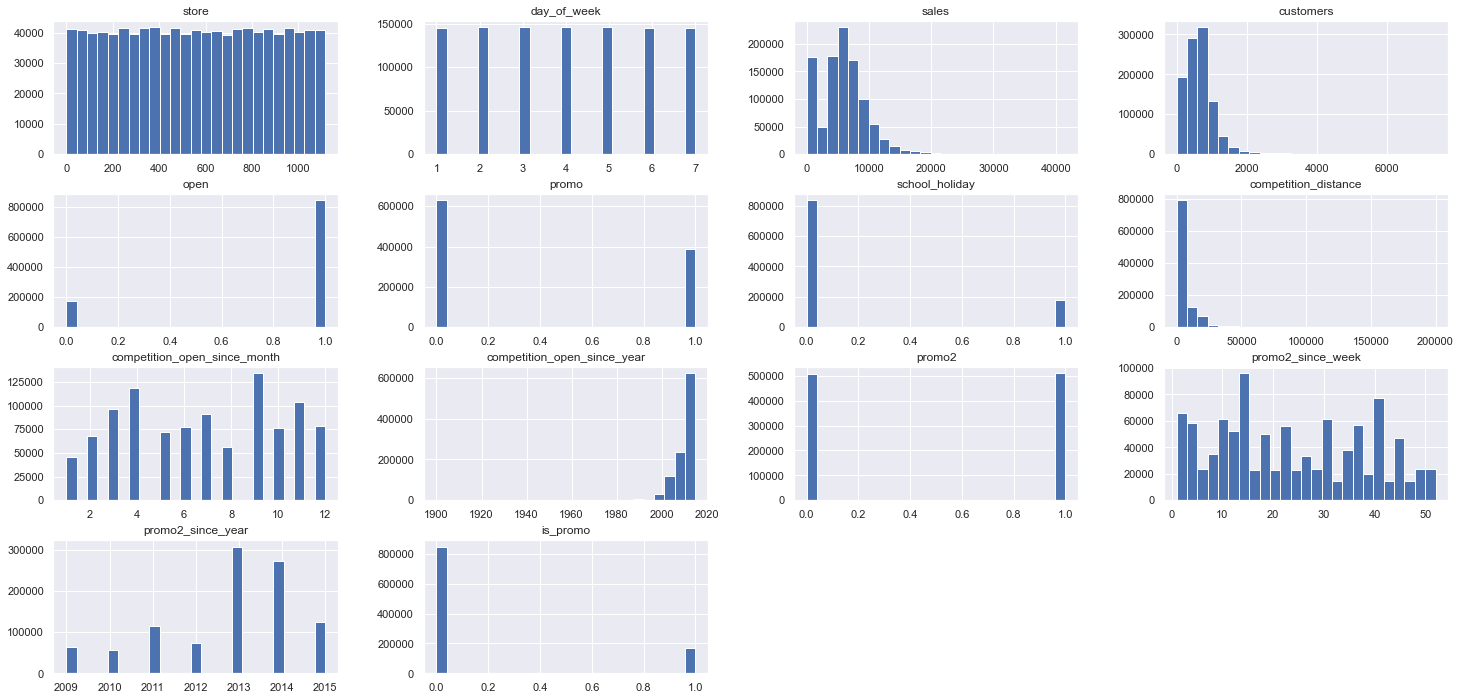

In [36]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [37]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [38]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126        christimas
Name: state_holiday, dtype: object

In [39]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [40]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

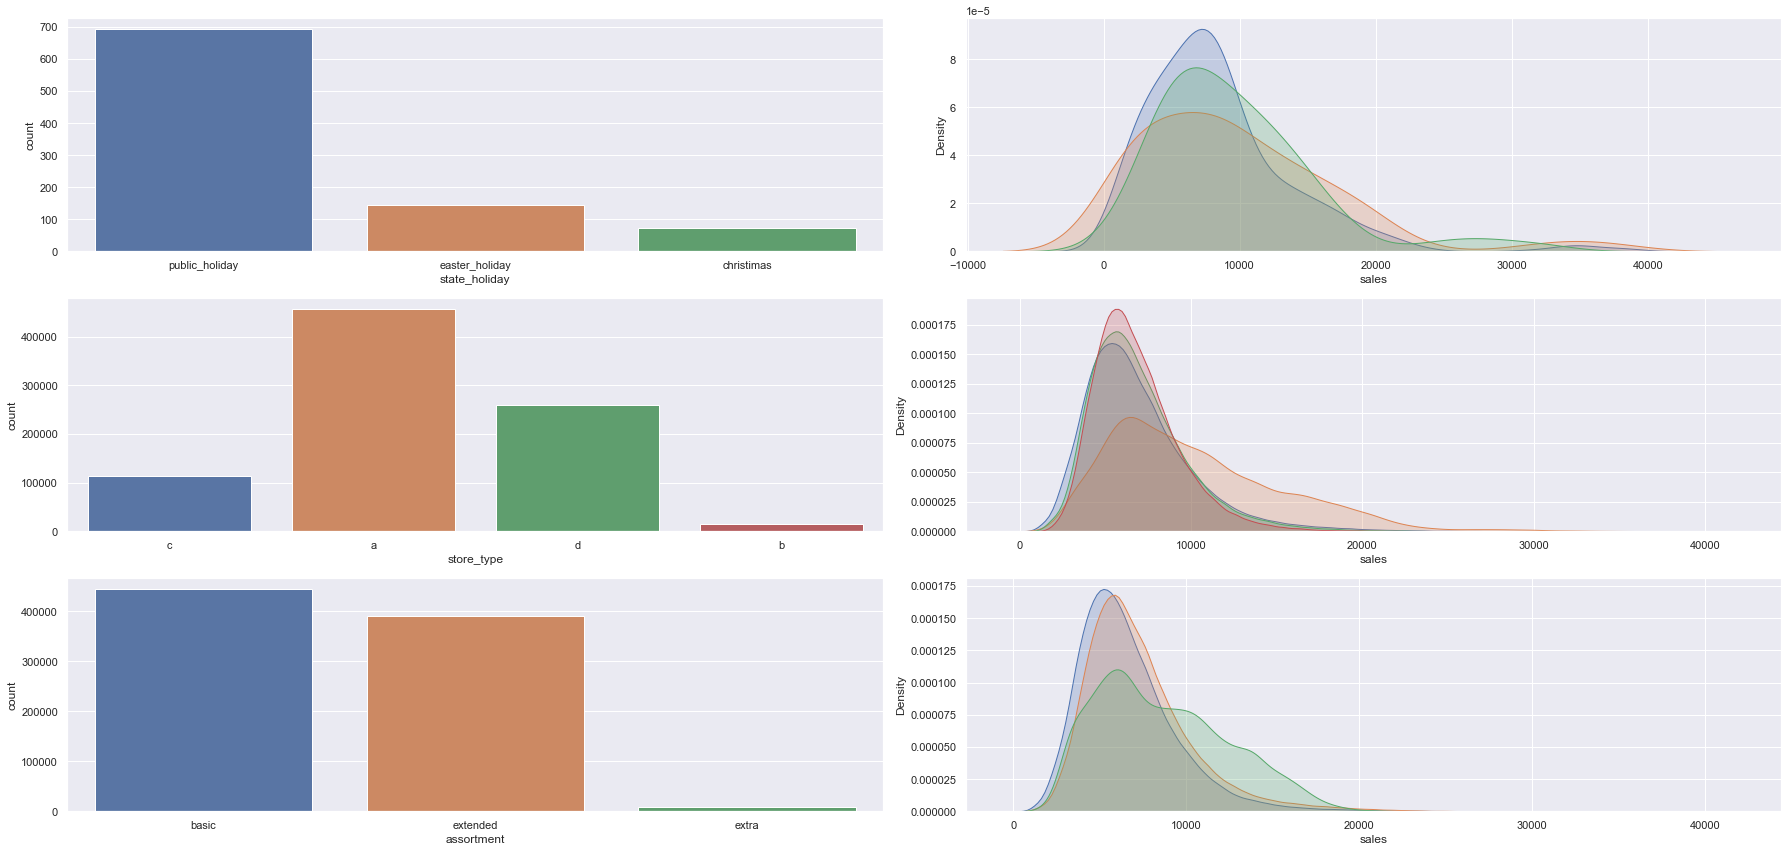

In [41]:
#state_holiday
plt.subplot (3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day'] #filtro
sns.countplot (x='state_holiday', data=a)

plt.subplot (3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label='christimas', shade=True)

#store_type
plt.subplot (3, 2, 3)
sns.countplot (x='store_type', data=df4)

plt.subplot (3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot (3, 2, 5)
sns.countplot (x='assortment', data=df4)

plt.subplot (3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.tight_layout();


## 4.2 Analise Bivariada
Analisar o impacto de uma variável em uma variável resposta/Validação das hipóteses.

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** - Lojas com o MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

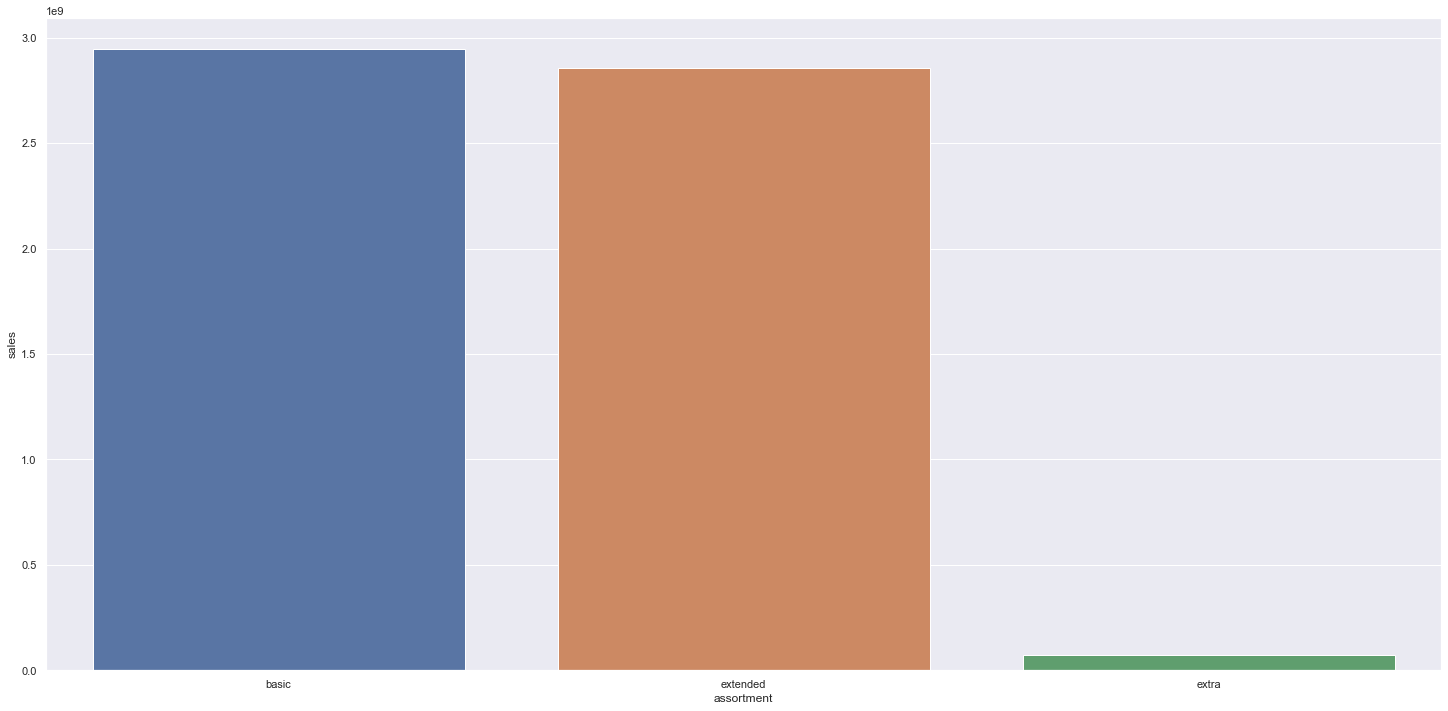

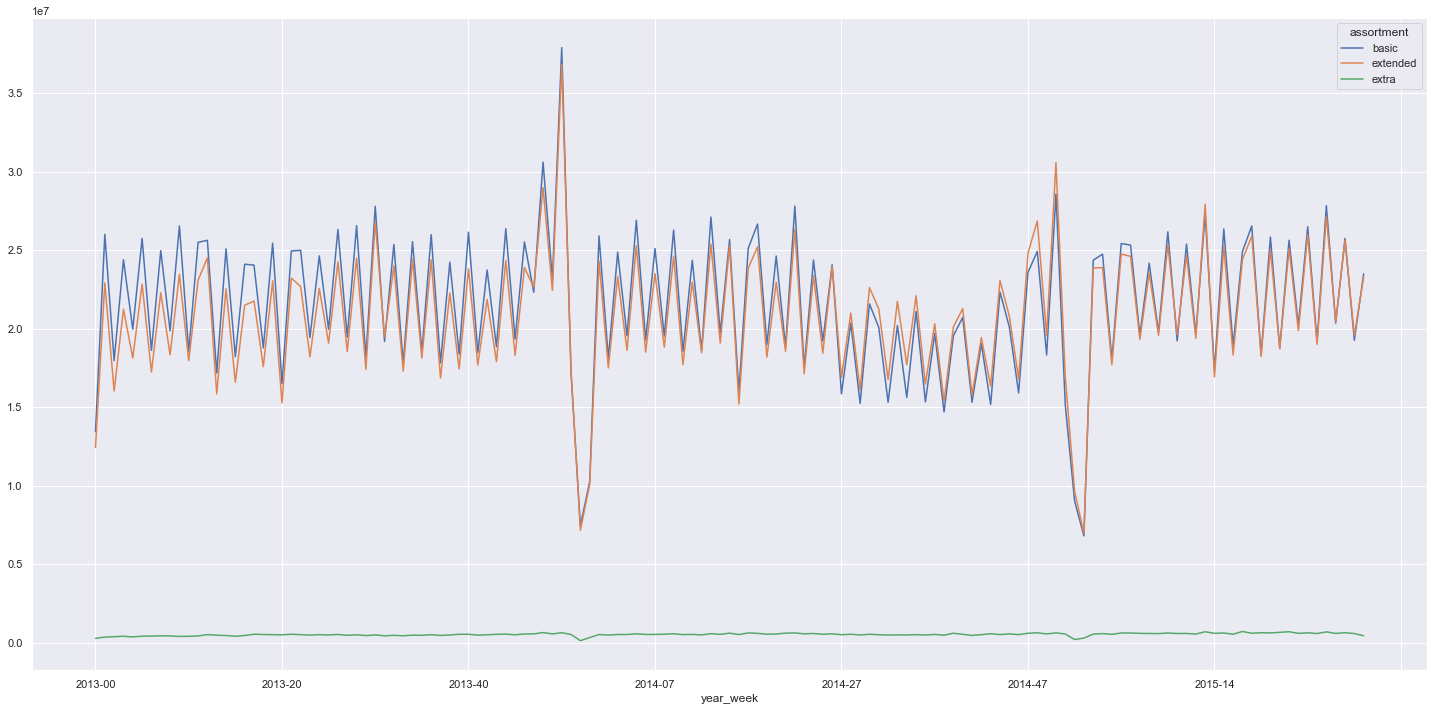

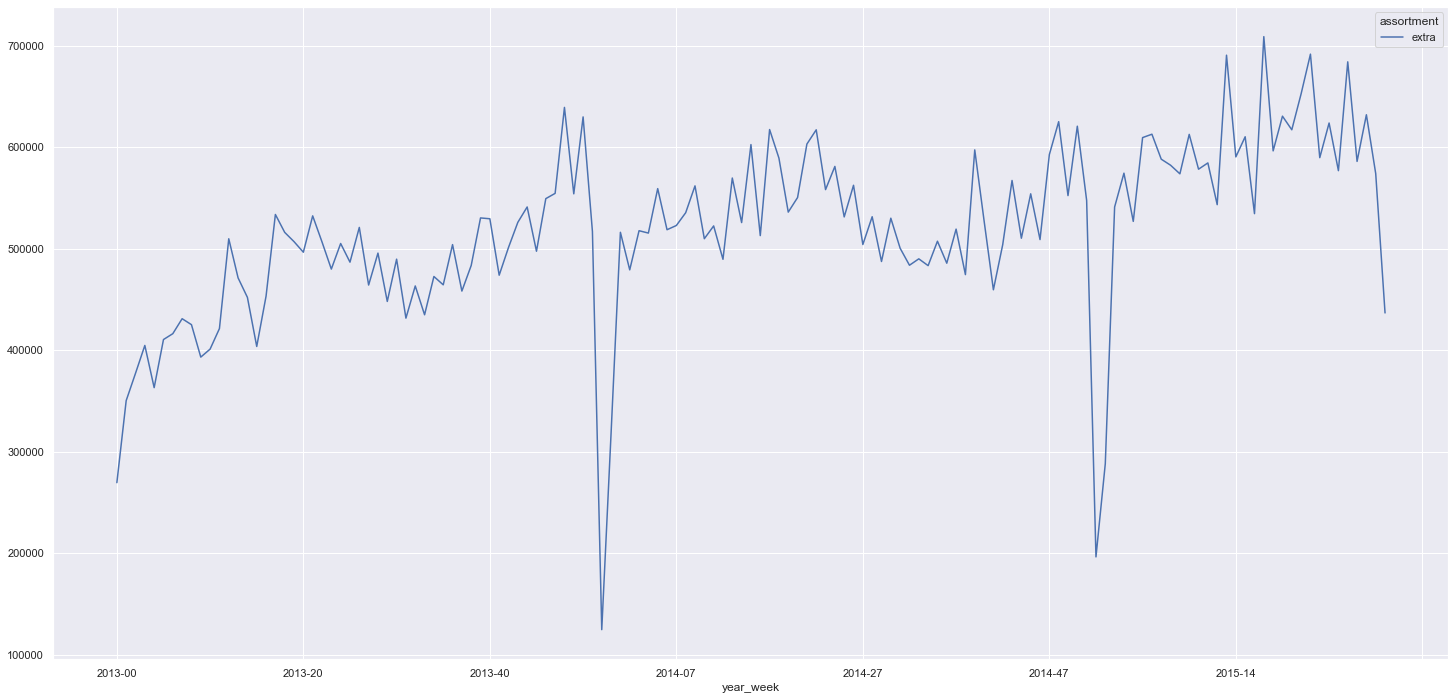

In [42]:
#verificando a primeira etapa da hipótese
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot (x='assortment', y='sales', data=aux1);

#aprofundando a análise para verificar se o comportamento das vendas se manteve ao longo do tempo
aux2 = df4[[ 'year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

#filtrando o outlier separadamente
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** - Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

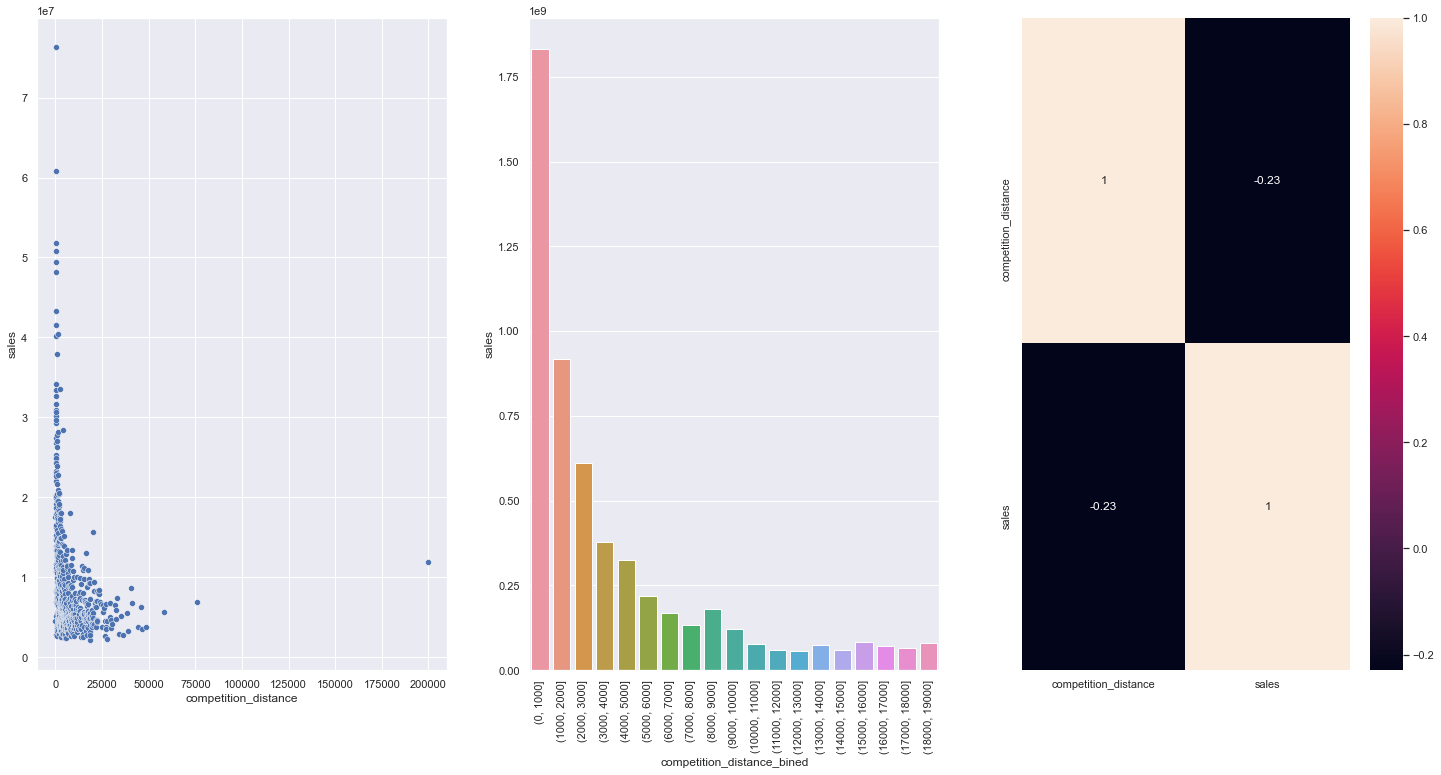

In [43]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (1, 3, 1)
sns.scatterplot (x='competition_distance', y='sales', data=aux1);

plt.subplot (1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_bined'] = pd.cut (aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()
sns.barplot (x='competition_distance_bined', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [44]:
aux1.sample(4)

,competition_distance,sales,competition_distance_bined
255,3200.0,7270804,"(3000.0, 4000.0]"
611,22330.0,8269484,NaN
600,20260.0,4089245,NaN
432,7910.0,5933077,"(7000.0, 8000.0]"


### H3. Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** - Lojas com competidores a MAIS TEMPO vendem MENOS.

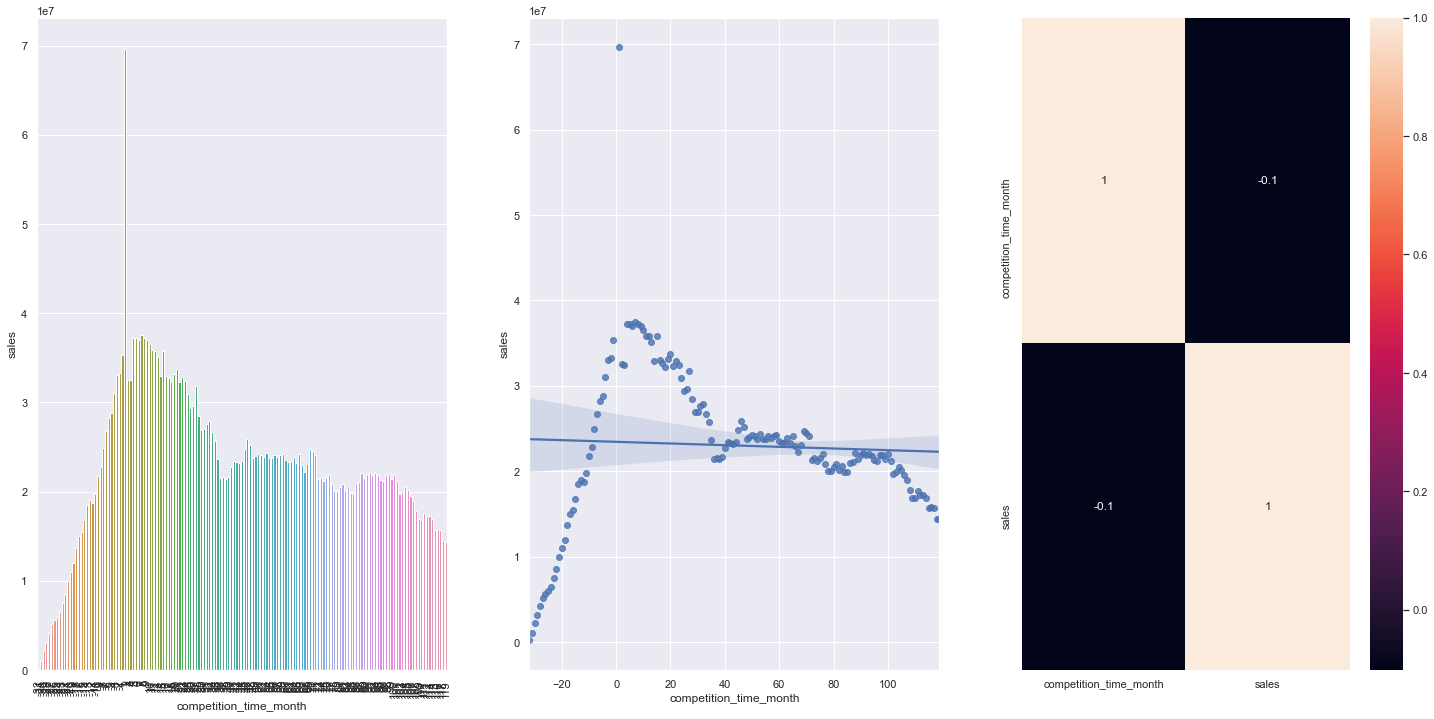

In [45]:
plt.subplot (1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot (1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr(method="pearson"), annot=True);


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com promoções ativas por mais tempo VENDEM MENOS, depois de um certo período de promoção.


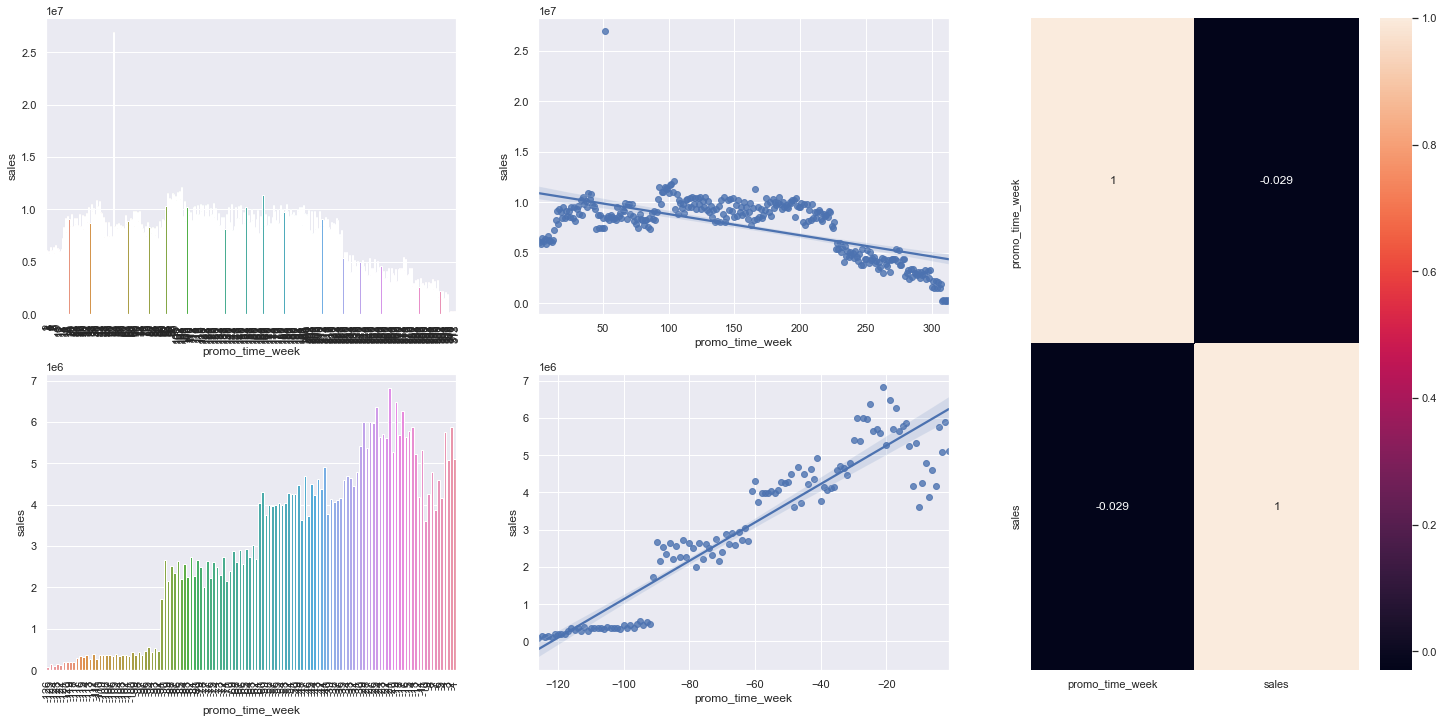

In [46]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec (2, 3)

plt.subplot (grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] #extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot (grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot (grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] #regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot (grid [1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot (grid [:, 2])
sns.heatmap (aux1.corr(method="pearson"), annot=True);


### <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s>



### H6. Lojas com mais promoções consecutivas (extendidas) deveriam vender mais.
**FALSA** - Lojas com mais promoções consecutivas VENDEM MENOS.

In [47]:
#verificando a soma das vendas de acordo com a atual promoção das lojas (tradicional ou extendida):

df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


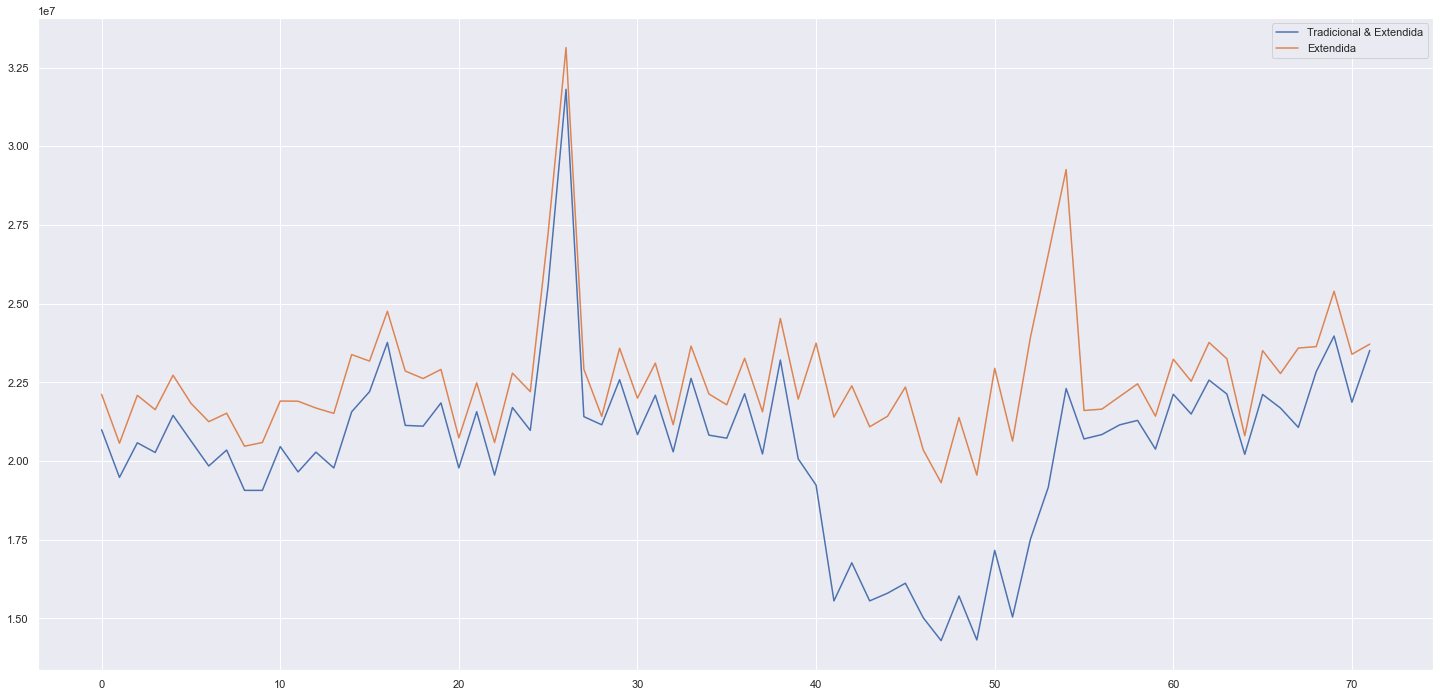

In [48]:
#VERIFICANDO O COMPORTAMENTO AO LONGO DO TEMPO:
#Será que lojas que tiveram promoção apenas no período tradicional mudaram de comportamento ao entrar no período de promoção extendida?

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** - Lojas abertas durante o feriado de natal VENDEM MENOS.

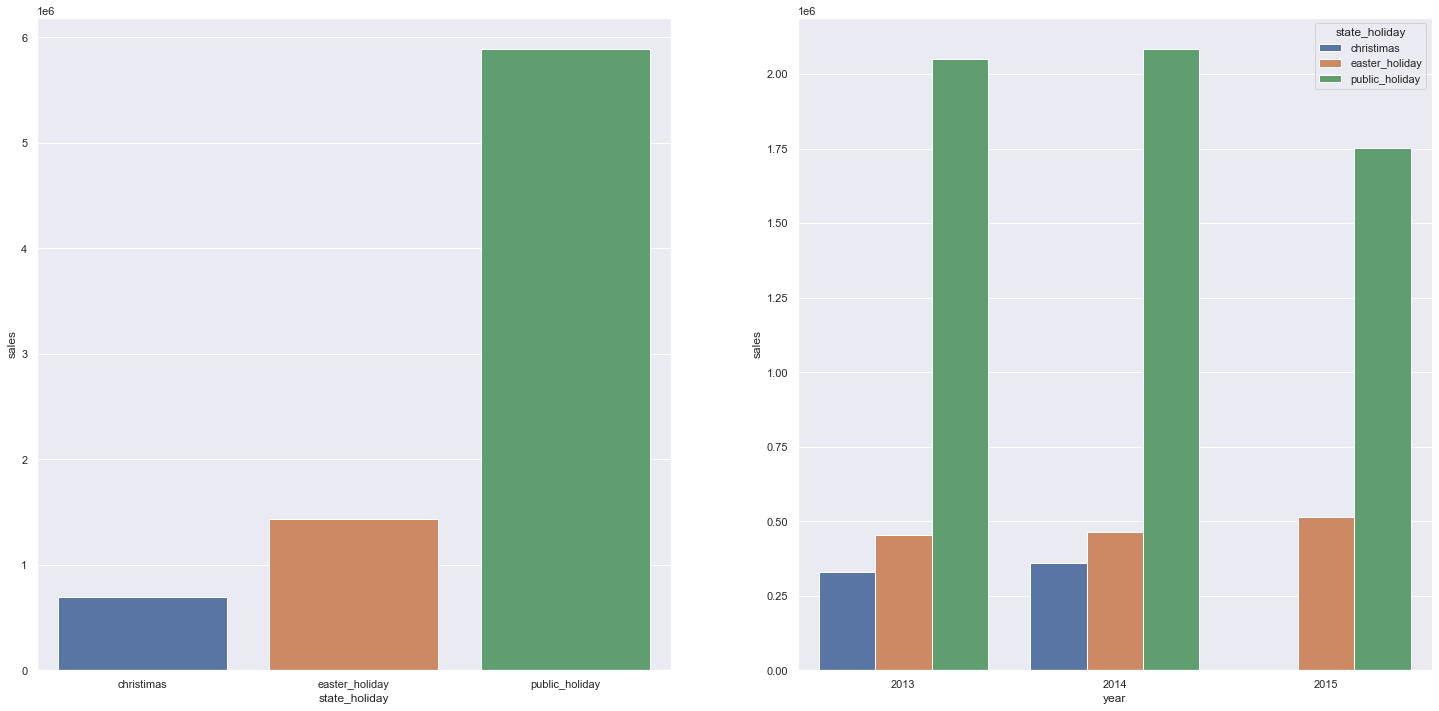

In [49]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot (1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot (1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H9. Lojas deveriam vender mais ao longo dos anos.
**FALSA** - Lojas vendem MENOS ao longo dos anos.

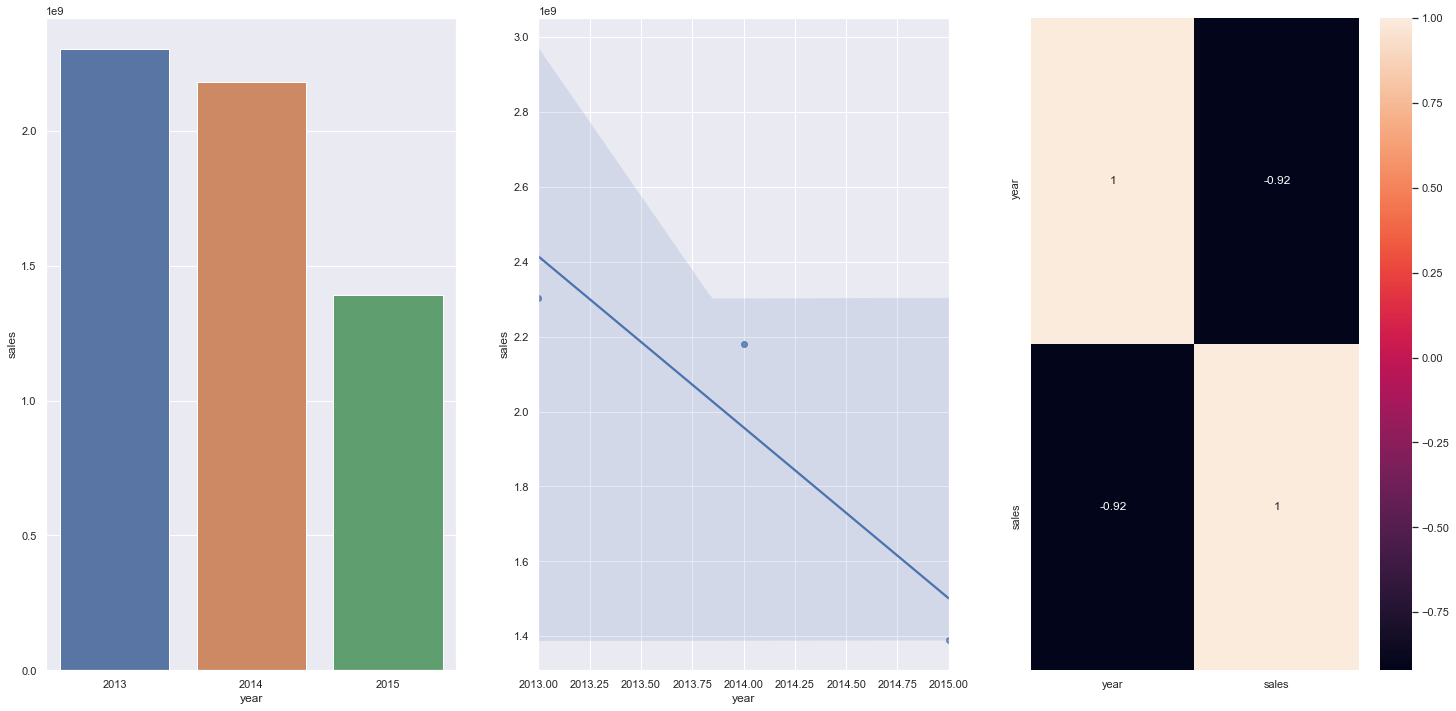

In [50]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot (1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** - Lojas vendem MENOS no segundo semestre do ano.

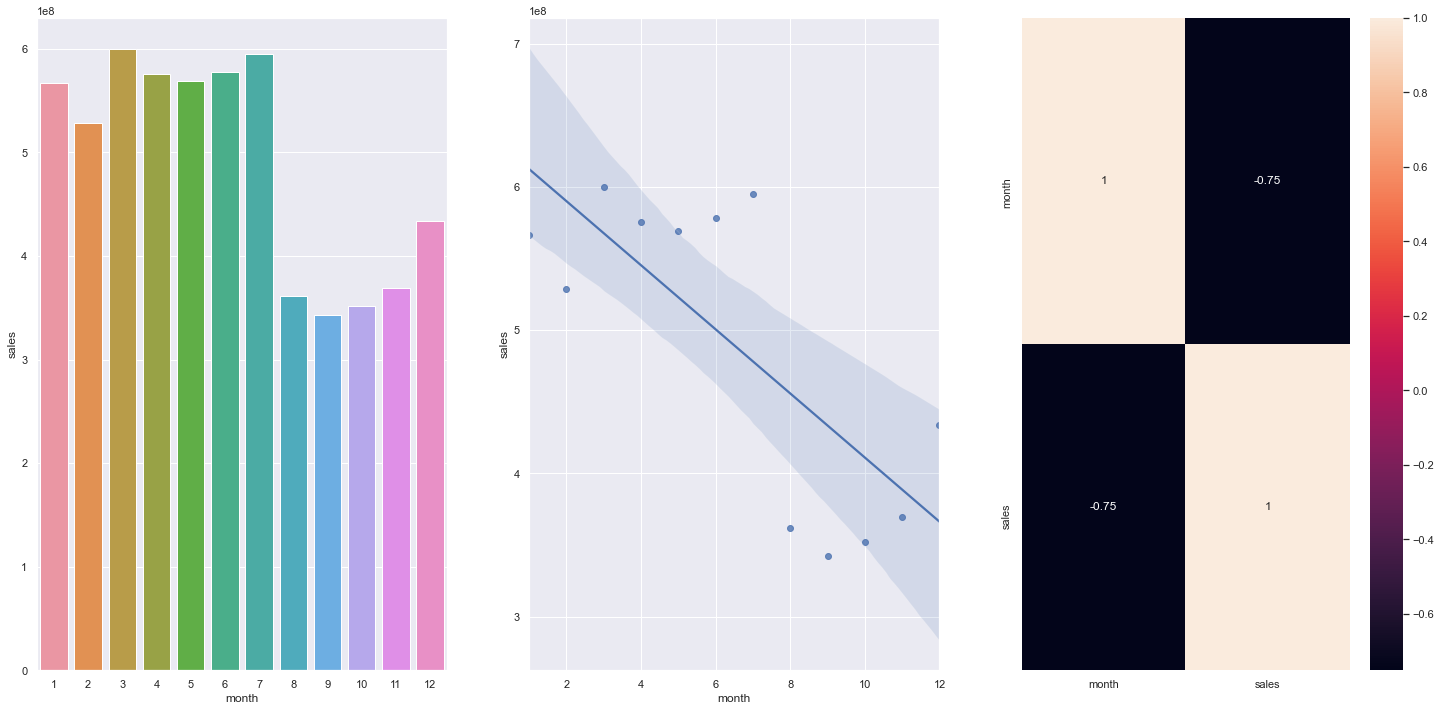

In [51]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot (1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** - Lojas VENDEM MAIS depois do dia 10 de cada mês.

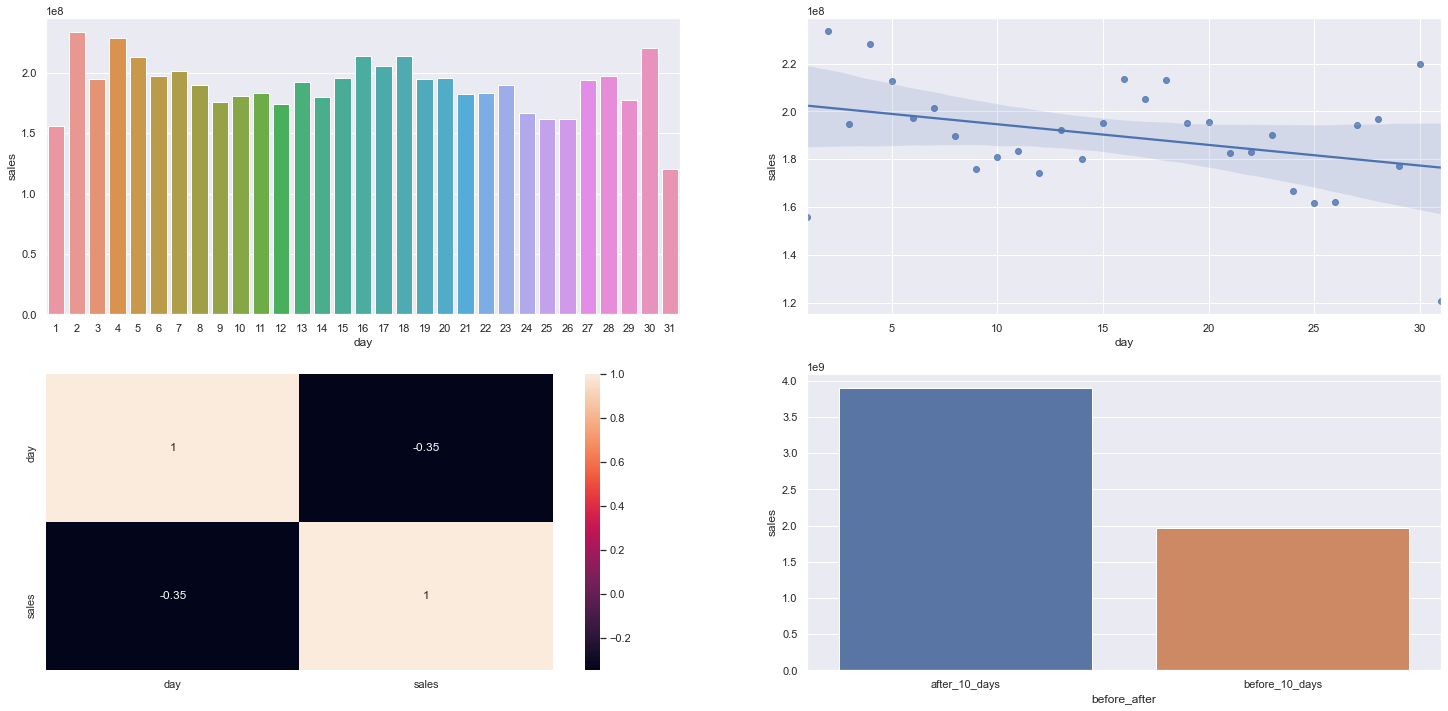

In [52]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot (2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot (2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot (2, 2, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True)

plt.subplot (2, 2, 4)
aux1['before_after'] = aux1['day'].apply (lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot (x='before_after', y='sales', data=aux2);


### H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** -Lojas VENDEM MENOS nos finais de semana.

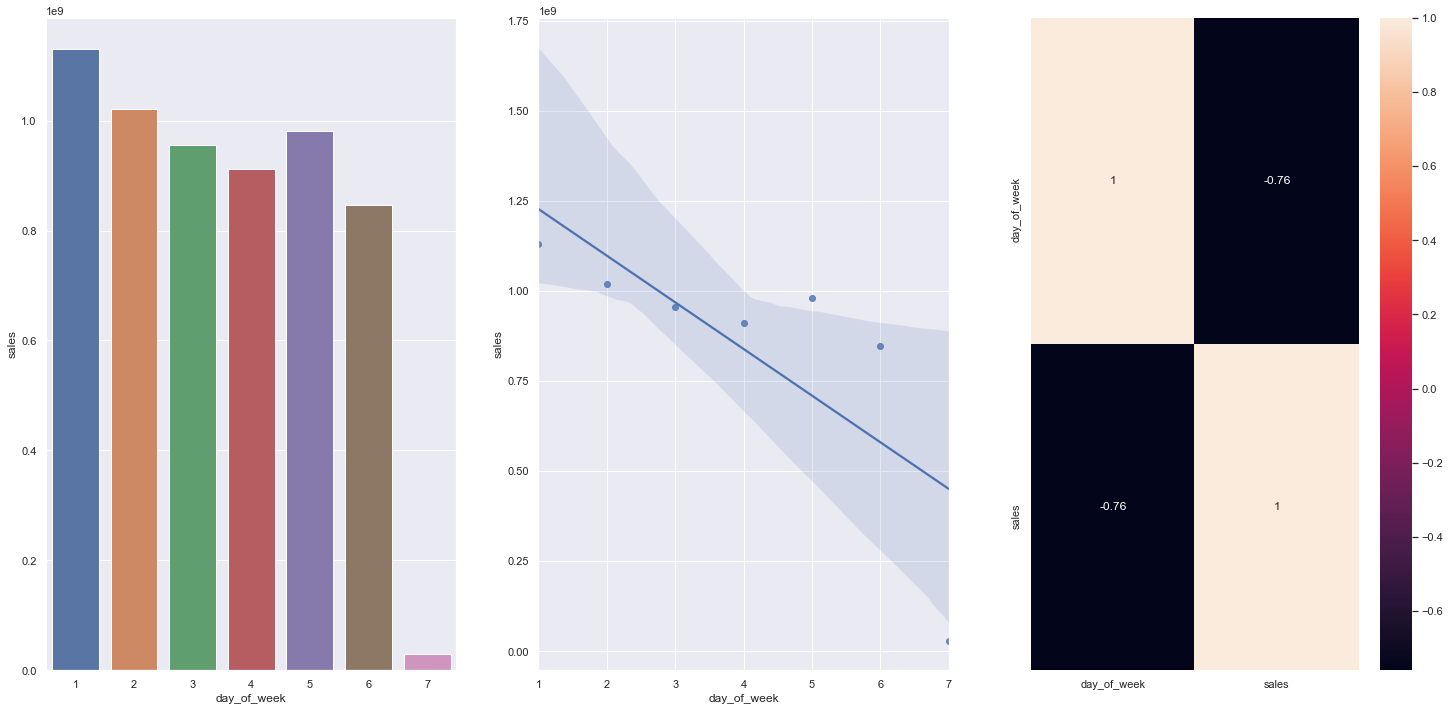

In [53]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot (1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H13. Lojas deveriam vender menos durante os feriado escolares.
**VERDADEIRA** - Lojas VENDEM MENOS durante os feriados escolares (exceto em Agosto).

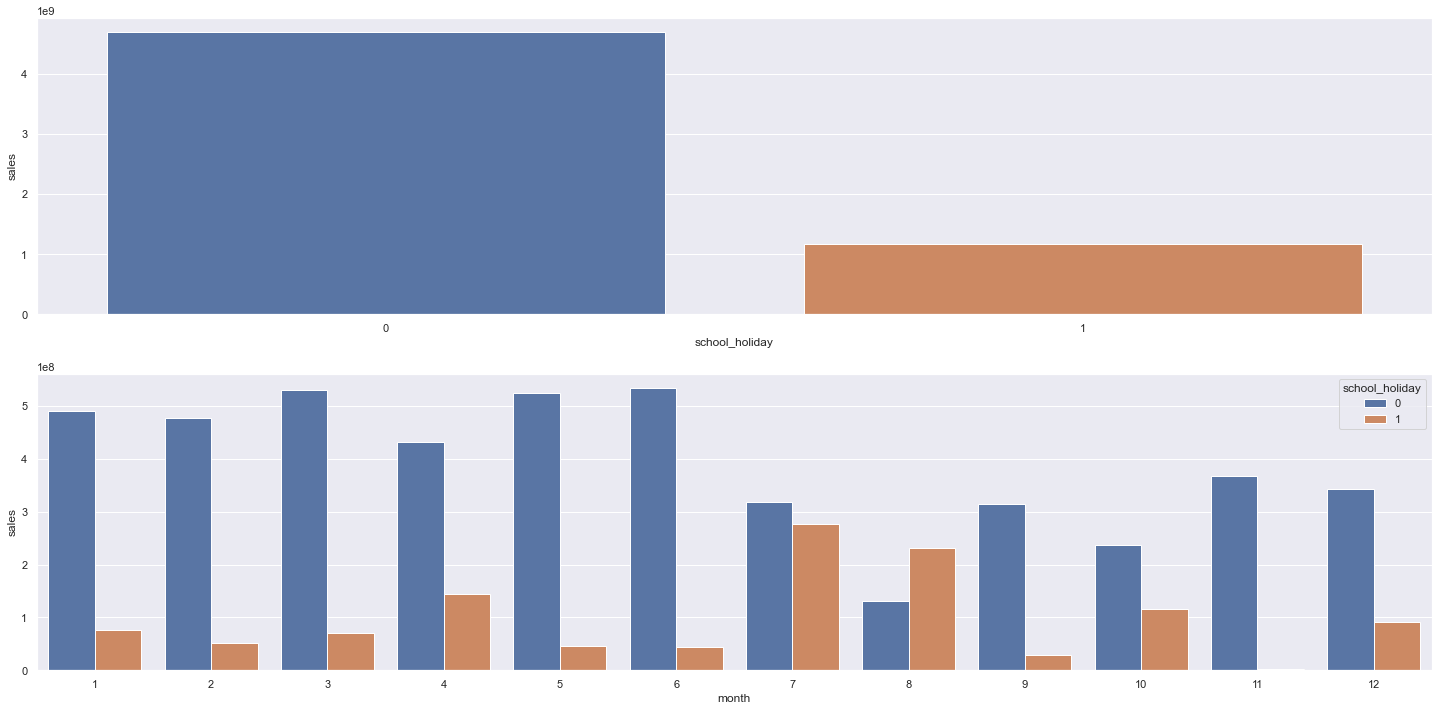

In [54]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot (2, 1, 1)
sns.barplot (x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot (2, 1, 2)
sns.barplot (x='month', y='sales', hue='school_holiday', data=aux2);

## 4.2.1 Resumo das Hipóteses

In [55]:
from tabulate import tabulate

In [56]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Media'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H7          Falsa        Baixa
H8          Falsa        Media
H9          Falsa        Alta
H10         Falsa        Alta
H11         Verdadeira   Alta
H12         Verdadeira   Alta
H13         Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

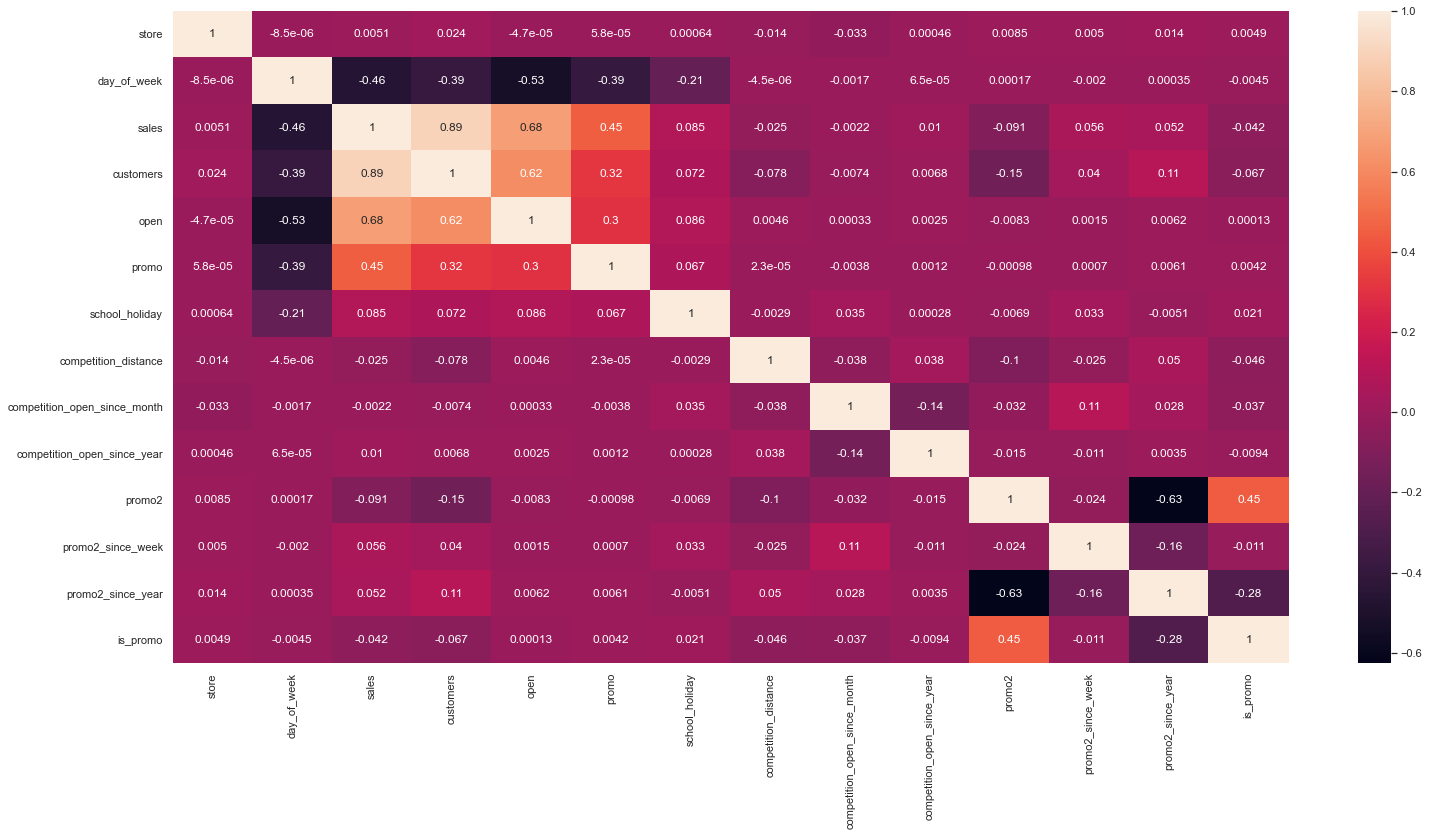

In [57]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

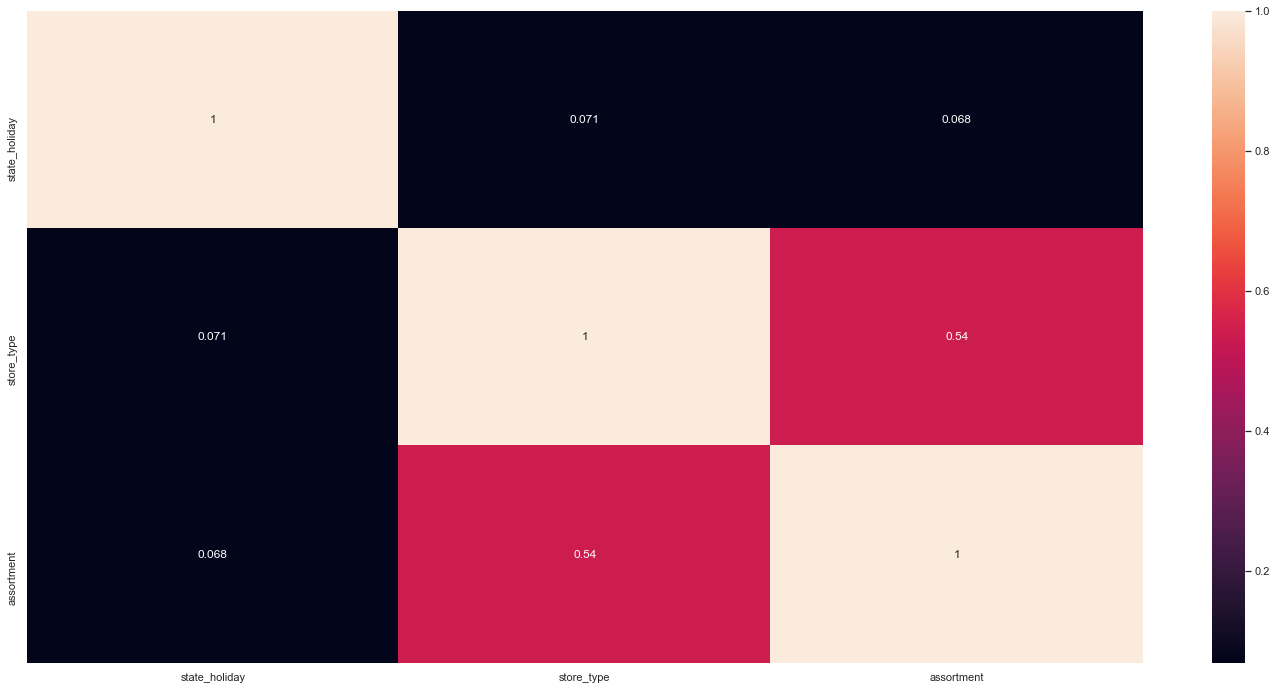

In [59]:
#categorical data only
a = df4.select_dtypes(include = 'object')

#calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#final dataset
d = pd.DataFrame ({'state_holiday': [a1, a2, a3],
                      'store_type': [a4, a5, a6],
                      'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0 DATA PREPARATION

In [60]:
df5 = df4.copy()

## 5.1. Normalization

- Due to the inexistance of normal variables in this dataset, we're not going to do any normalization.

## 5.2. Rescaling

- Let's select the variables to rescale:

In [61]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform (df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform (df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform (df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform (df5[['year']].values)

#OBS.: IF THERE'S OUTLIERS WE'RE GOING TO USE RobustScaler, SO IT'S IMPORTANT TO CHECK ON BY ONE.

## 5.3. Transformation

### 5.3.1. Encoding

In [62]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies (df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform (df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [63]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. Nature Transformation

In [65]:
# TRANSFORMING CICLICAL VARIABLES INTO NEW ONES WITH SIN AND COSIN INFORMATION, CALCULATED FROM THE ORIGINAL:

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x * (2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x * (2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x * (2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x * (2. * np.pi/52)))


In [66]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 FEATURE SELECTION

In [67]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [68]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [69]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop (cols_drop, axis=1)

In [70]:
#verifying the priod to separate the training data from the test data:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

#The first date until 18-06-2015 it's going to be the trainning data, and from 19-06-2015 to the last date will be the testing data.

Timestamp('2015-06-19 00:00:00')

In [71]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [76]:
#training and test dataset for boruta
#x_train_n = x_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

#define Random Forest RegressorA
#rf = RandomForestRegressor (n_jobs=-1)

#define boruta
#boruta = BorutaPy (rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [77]:
#cols_selected = boruta.support_.tolist()

#best features

#x_train_fs = x_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected columns by boruta

#cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)

## 6.3 Manual Feature Selection

In [72]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
#cols_selected_boruta.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODELLING

In [73]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 Average Model

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [75]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

In [76]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#preditcion
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [77]:
from sklearn.linear_model import LinearRegression

In [78]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.3 Linear Regression Regularized Model - Lasso

In [79]:
from sklearn.linear_model import Lasso

In [80]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## 7.4 Random Forest Regressor

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [83]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


## 7.5 XGBoost Regressor

In [ ]:
import xgboost as xgb

In [ ]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

## 7.6 Compare Model's Performance 

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

In [ ]:
X_train.head()